In [2]:
# import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.plot import show
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile as tiff
import os
import random
from sklearn.model_selection import train_test_split
from rasterio.plot import reshape_as_raster, reshape_as_image
import numpy as np

In [135]:
shapefile_path = '../final.shp'
tiff_path = '/mnt/disk/solid_waste/interest.tif'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


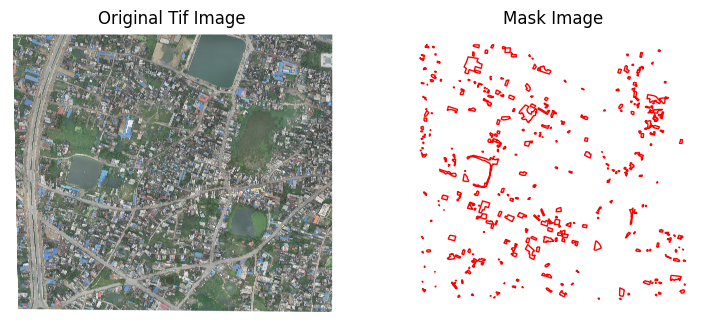

In [136]:
# Read the shapefile and TIFF image
gdf = gpd.read_file(shapefile_path)
src = rasterio.open(tiff_path)

# Plot the TIFF image
bands = src.read((1,2,3))
red_band = bands[0, :, :]
green_band = bands[1, :, :]
blue_band = bands[2, :, :]
# plt.figure(figsize=(5, 5))
image = np.dstack((red_band, green_band, blue_band))
# Overlay the shapefile
# gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red')

# plt.show()
plt.figure(figsize=(18, 8))
plt.subplot(221)
plt.title('Original Tif Image')
plt.axis('off')
plt.imshow(image)
plt.subplot(232)
plt.title('Mask Image')
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red')
# plt.show()
plt.axis('off')
plt.show()

In [137]:
image.shape

(10175, 11795, 3)

In [138]:
image[:,:,-1].shape

(10175, 11795)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


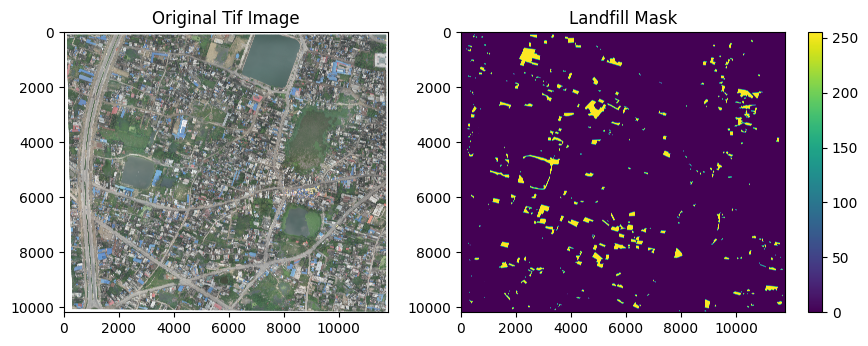

In [139]:
out_meta = src.meta
mask = geometry_mask(gdf['geometry'], out_shape=image[:,:,-1].shape, transform=out_meta['transform'], invert=True)
out_meta.update(dtype='uint8', count=1, nodata=0)
mask_output_path = 'maskout.tif'
with rasterio.open(mask_output_path, 'w', **out_meta) as dest:
    dest.write(mask * 255, 1)  # Scaling the mask to 0-255 range

with rasterio.open(mask_output_path) as mask_src:
    mask_array = mask_src.read(1)

# plt.figure(figsize=(8, 8))

# plt.show()
plt.figure(figsize=(20, 8))
plt.subplot(221)
plt.title('Original Tif Image')
# plt.axis('off')
plt.imshow(image)
plt.subplot(232)
plt.imshow(mask_array)
plt.title('Landfill Mask')
plt.colorbar()
# plt.axis('off')
plt.show()



In [140]:
image.shape

(10175, 11795, 3)

In [38]:
from PIL import Image

In [141]:
 # Split the geotiff image and mask into smaller patches
patch_size = 256  # Define the patch size
step_size = 256  # Define the step size for overlapping patches
image_patches = patchify(image, (patch_size, patch_size,3), step=step_size)  # Patchify the image
mask_patches = patchify(mask_array, (patch_size, patch_size), step=step_size)  # Patchify the mask

In [142]:
print(image_patches.shape)
print(mask_patches.shape)

(39, 46, 1, 256, 256, 3)
(39, 46, 256, 256)


In [143]:
X = np.array([image_patches[i, j, :, :,:] for i in range(image_patches.shape[0]) for j in range(image_patches.shape[1])])
y = np.array([mask_patches[i, j, :, :] for i in range(mask_patches.shape[0]) for j in range(mask_patches.shape[1])])

In [144]:
print(X.shape)
print(y.shape)

(1794, 1, 256, 256, 3)
(1794, 256, 256)


In [145]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [146]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1524, 1, 256, 256, 3)
(1524, 256, 256)
(270, 1, 256, 256, 3)
(270, 256, 256)


In [147]:
data_dir = 'Data'

# Modify the paths for the image and mask data directories
train_image_data_dir = 'Data/train_images/train'
train_mask_data_dir = 'Data/train_masks/train'
val_image_data_dir = 'Data/val_images/val'
val_mask_data_dir = 'Data/val_masks/val'

In [148]:
# Create the necessary directories if they don't exist
for directory in [data_dir, train_image_data_dir, train_mask_data_dir, val_image_data_dir, val_mask_data_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [152]:
X_train.shape

(1524, 1, 256, 256, 3)

In [156]:
for i, data in enumerate(zip(X_train, y_train)):
    image_patch, mask_patch = data
    tiff.imwrite(f'{train_image_data_dir}/img_{i}.tif', image_patch[0].astype(np.uint8))
    tiff.imwrite(f'{train_mask_data_dir}/msk_{i}.tif', mask_patch)

for i, data in enumerate(zip(X_val, y_val)):
    image_patch, mask_patch = data
    tiff.imwrite(f'{val_image_data_dir}/img_{i}.tif', image_patch[0].astype(np.uint8))
    tiff.imwrite(f'{val_mask_data_dir}/msk_{i}.tif', mask_patch)


In [157]:
# Function to read an image and its mask from separate folders
def read_image_and_mask_separate(image_dir, mask_dir, index, data_type):
    image_path = f'{image_dir}/img_{index}.tiff'
    mask_path = f'{mask_dir}/msk_{index}.tiff'
    image = tiff.imread(image_path)
    mask = tiff.imread(mask_path)
    return image, mask

# Updated function to read the images and masks
def read_image_and_mask(image_dir, mask_dir, index, data_type):
    if data_type == 'train':
        return read_image_and_mask_separate(train_image_data_dir, train_mask_data_dir, index, data_type)
    elif data_type == 'val':
        return read_image_and_mask_separate(val_image_data_dir, val_mask_data_dir, index, data_type)
    # elif data_type == 'test':
    #     return read_image_and_mask_separate(test_image_data_dir, test_mask_data_dir, index, data_type)
    else:
        print("Invalid data type.")

In [158]:
# Update the data directories for images and masks
train_image_data_dir = 'Data/train_images/train'
train_mask_data_dir = 'Data/train_masks/train'
val_image_data_dir = 'Data/val_images/val'
val_mask_data_dir = 'Data/val_masks/val'

In [159]:
# Print the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
# print("Shape of X_test:", X_test.shape)
# print("Shape of y_test:", y_test.shape)

Shape of X_train: (1524, 1, 256, 256, 3)
Shape of y_train: (1524, 256, 256)
Shape of X_val: (270, 1, 256, 256, 3)
Shape of y_val: (270, 256, 256)


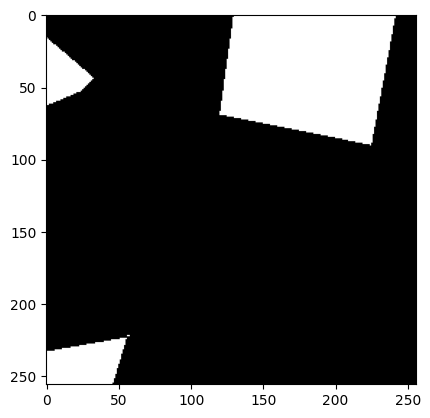

In [162]:
import cv2
img = cv2.imread('Data/train_images/train/img_4.tif')
# img = rasterio.open('Data/train_masks/train/msk_4.tif').read(1)
img = cv2.imread('Data/train_masks/train/msk_4.tif')
# img = reshape_as_image(img)
plt.imshow(img)

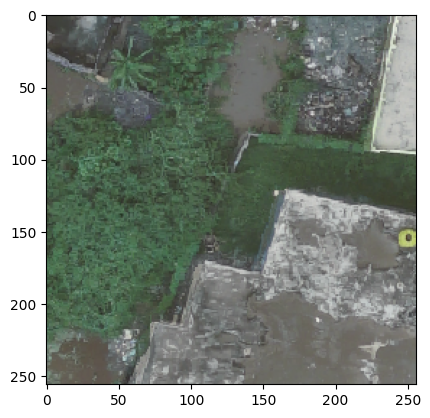

In [172]:
img = cv2.imread('Data/train_images/train/img_4.tif')
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img = rasterio.open('Data/train_images/train/img_1001.tif').read()
# img = reshape_as_image(img)
plt.imshow(img)

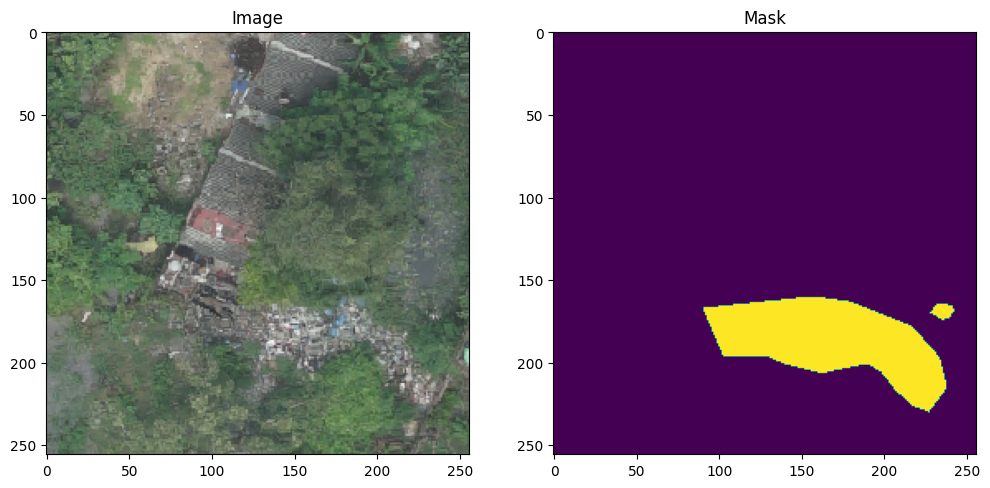

In [195]:
# import cv2
train_img_dir = "Data/train_images/train/"
train_mask_dir = "Data/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

# print(num_images)
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(f'{train_img_dir}img_{img_num}.tif', 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(f'{train_mask_dir}msk_{img_num}.tif', 0)
# img_for_plot = rasterio.open(f'{train_img_dir}img_{img_num}.tif').read()
# img_for_plot = reshape_as_image(img_for_plot)

# mask_for_plot =rasterio.open(f'{train_mask_dir}msk_{img_num}.tif').read(1)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot)
plt.title('Mask')
plt.show()


In [196]:
!nvidia-smi

Tue Nov 28 23:59:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        On   | 00000000:21:00.0 Off |                  N/A |
| 64%   84C    P0    76W / 105W |   7906MiB /  8192MiB |     61%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------